<a href="https://colab.research.google.com/github/didulanthaisuru/time_series_forecasting/blob/main/colab_data_visualized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:

import os

# List files in the sample_data folder
sample_data_path = '/content/drive/MyDrive'
files = os.listdir(sample_data_path)
print(files)

['mee', 'IMG-20200920-WA0041.jpg', 'IMG-20200920-WA0038.jpg', 'IMG-20200919-WA0005.jpg', 'IMG-20200919-WA0007.jpg', 'IMG-20200919-WA0006.jpg', 'IMG-20200919-WA0004.jpg', 'Scanned_20201015-1304.pdf', 'IMG-20201020-WA0061.jpg', 'IMG-20201020-WA0059.jpg', 'IMG-20201020-WA0060.jpg', 'IMG-20201020-WA0058.jpg', 'IMG-20201020-WA0057.jpg', 'IMG-20201020-WA0056.jpg', 'IMG-20201020-WA0055.jpg', 'IMG-20201020-WA0053.jpg', 'IMG-20201020-WA0054.jpg', 'IMG-20201020-WA0052.jpg', 'IMG-20201020-WA0050.jpg', 'IMG-20201020-WA0051.jpg', 'IMG-20201020-WA0049.jpg', 'IMG-20201020-WA0048.jpg', 'IMG-20201019-WA0043.jpg', 'IMG-20201019-WA0007.jpg', 'IMG-20201019-WA0006.jpg', 'FB_IMG_16043940700818763.jpg', 'IMG-20201125-WA0022.jpg', 'STK-20201111-WA0017.webp', 'WhatsApp Chat with ❤.txt', 'STK-20201108-WA0074.webp', 'STK-20201108-WA0120.webp', 'VID-20201129-WA0009.mp4', 'Heat tute Thapamithiya.pdf', 'Screenshot (15 Dec 2020 00:47:37)', 'Screenshot (15 Dec 2020 02:20:32)', 'Screenshot (23 Dec 2020 01:42:24)', 'Sc

In [ ]:
file_path = '/content/drive/MyDrive/ShiharaFinalizedDatasetExpenses.xlsx'

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
import hdbscan
import numpy as np
from sklearn.preprocessing import StandardScaler,normalize
from collections import Counter
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
df=pd.read_excel(file_path)

In [ ]:
df.head()

,Date,Particulars,Payments,Receipts,Balance
0,2022-12-27,IB CEFT CHGS K A Kumaranayek,30.0,NaN,8449.35
1,2022-12-27,PURCHASE UNIVERSITY GRANTS C,50.0,NaN,8399.35
2,2022-12-28,PURCHASE KEELLS SUPER - MORA,5000.0,NaN,3399.35
3,2023-01-04,shiroma,3000.0,NaN,75440.92
4,2023-01-04,IB CEFT CHGS tvf Fernando,30.0,NaN,75410.92


In [ ]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
# Step 3: Data Refinement - Text Preprocessing

In [ ]:
# Create a dictionary of abbreviations
abbreviations = {
    'PYT': 'payment',
    'TRF': 'transfer',
    'DEP': 'deposit',
    'WDL': 'withdrawal',
    'WD': 'withdrawal',
    'POS': 'point of sale',
    'ATM': 'atm withdrawal',
    'CHQ': 'cheque',
    'DD': 'demand draft',
    'BT': 'bank transfer',
    'ACH': 'automated clearing house',
    'NEFT': 'national electronic funds transfer',
    'RTGS': 'real-time gross settlement',
    'IMPS': 'immediate payment service',
    'UPI': 'unified payments interface',
    'INT': 'interest',
    'CHG': 'charge',
    'FEE': 'fee',
    'TXN': 'transaction',
    'REV': 'reversal',
    'EMI': 'equated monthly installment',
    'CC': 'credit card',
    'POS REF': 'point of sale refund',
    'BIL': 'bill payment',
    'BILP': 'bill payment',
    'INV': 'investment',
    'REF': 'refund',
    'SAL': 'salary credit',
    'SL': 'salary credit',
    'TFR': 'transfer'
}


In [ ]:
# Predefined category keywords
category_keywords = {
    "Clothing and Apparel": ["nolimit", "piyara fashion", "spring & summer", "kandy", "cool planet", "odel", "mimosa", "zigzag", "super fashion"],
    "Grocery": ["keels", "foodcity", "sinhala", "cargills", "luluhyper", "laugfs super market"],
    "Electronics": ["dialog", "sri lanka telecom", "mobitel", "samsung", "huawei", "lg"],
    "Home Appliances": ["abans", "lg", "singer", "damro"],
    "Restaurants": ["kfc", "pizza hut", "burger king", "dominos", "sarasavi"],
    "Fuel": ["lanka fuel", "caltex", "shell", "petrol", "diesel"],
}

In [ ]:
# Step 3.1: Normalize Capitalization and Expand Abbreviations
def clean_text(text, abbr_dict):
    # Convert text to lowercase
    text = text.lower()

    # Expand abbreviations
    for abbr, full_form in abbr_dict.items():
        text = re.sub(rf'\b{abbr.lower()}\b', full_form.lower(), text)

    text = re.sub(r'\s+', ' ', text).strip() #remove extra spaces

    return text

# Apply text cleaning to 'Particulars' column
df['cleaned_particulars'] = df['Particulars'].apply(lambda x: clean_text(str(x), abbreviations))

In [ ]:
# Step 3.2: Categorize based on Keywords
def categorize_by_keywords(description):
    description_lower = description.lower()
    for category, keywords in category_keywords.items():
        if any(keyword in description_lower for keyword in keywords):
            return category
    return "Uncategorized"

In [ ]:
# Apply categorization for key words
df['Category'] = df['cleaned_particulars'].apply(lambda x: categorize_by_keywords(x))
# Step 4: Separate Uncategorized Transactions
uncategorized_df = df[df['Category'] == "Uncategorized"].copy()

In [ ]:
# Step 5: Use Sentence Transformers to Create Embeddings for Uncategorized Data

# Initialize the sentence transformer model
# model = SentenceTransformer('all-mpnet-base-v2')
model = SentenceTransformer('sentence-transformers/gtr-t5-large')
# Generate embeddings for the cleaned text of uncategorized transactions
uncategorized_embeddings = model.encode(uncategorized_df['cleaned_particulars'].tolist())



scaler = StandardScaler()
uncategorized_embeddings_scaled = scaler.fit_transform(uncategorized_embeddings)

uncategorized_embeddings_normalized = normalize(uncategorized_embeddings_scaled)
similarity_matrix = cosine_similarity(uncategorized_embeddings_normalized)
# Convert similarity to distance (1 - similarity)
distance_matrix = 1 - similarity_matrix

# Ensure the distance matrix has no negative values
distance_matrix = np.clip(distance_matrix, 0, None)

dbscan_model = DBSCAN(eps=0.4, min_samples=2, metric="precomputed")
cluster_labels = dbscan_model.fit_predict(distance_matrix)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

In [ ]:
# Step 7: Add the cluster labels to the uncategorized dataframe
uncategorized_df['Cluster'] = cluster_labels


In [ ]:
# Step 8: Automatically Identify Cluster Names Based on Frequent Descriptions
def get_most_frequent_description(cluster_data):
    # Count occurrences of each description in the cluster
    description_counts = cluster_data['cleaned_particulars'].value_counts()
    # Return the most frequent description
    return description_counts.idxmax()

# Function to automatically assign a name to a cluster based on the most frequent description
def assign_cluster_name(cluster_data):
    # Get the most frequent description in the cluster
    most_frequent_description = get_most_frequent_description(cluster_data)
    # Return the most frequent description as the cluster name
    return most_frequent_description.upper()

# Function to clean cluster names by removing numbers and random strings
def clean_cluster_name(name):
    # Remove non-alphabetical characters (including numbers and special characters)
    name = re.sub(r'[^a-zA-Z\s]', '', name)
    return name.strip()

# Function to map the cluster name to a predefined category (if applicable)
def map_to_predefined_category(cluster_name):
    # Clean the cluster name first
    clean_name = clean_cluster_name(cluster_name)

    for category, keywords in category_keywords.items():
        if any(keyword in clean_name.lower() for keyword in keywords):
            return category
    return clean_name  # If no match, return the generated cluster name


#output prints


In [ ]:
df.head()

,Date,Particulars,Payments,Receipts,Balance,cleaned_particulars,Category
0,2022-12-27,IB CEFT CHGS K A Kumaranayek,30.0,NaN,8449.35,ib ceft chgs k a kumaranayek,Uncategorized
1,2022-12-27,PURCHASE UNIVERSITY GRANTS C,50.0,NaN,8399.35,purchase university grants c,Uncategorized
2,2022-12-28,PURCHASE KEELLS SUPER - MORA,5000.0,NaN,3399.35,purchase keells super - mora,Uncategorized
3,2023-01-04,shiroma,3000.0,NaN,75440.92,shiroma,Uncategorized
4,2023-01-04,IB CEFT CHGS tvf Fernando,30.0,NaN,75410.92,ib ceft chgs tvf fernando,Uncategorized


In [ ]:
# Step 9: Print Category Name and Transactions (Predefined Categories)
print("\n=== Predefined Categories ===")
for category in category_keywords.keys():
    category_transactions = df[df['Category'] == category]
    if not category_transactions.empty:
        print(f"\nCategory: {category}")
        print(category_transactions[['Date', 'Particulars', 'Payments', 'Receipts', 'Balance']])


=== Predefined Categories ===

Category: Clothing and Apparel
          Date                    Particulars  Payments  Receipts    Balance
18  2023-02-07               PURCHASE NOLIMIT   10033.0       NaN   87831.21
31  2023-03-08               PURCHASE NOLIMIT    8040.0       NaN   61394.58
90  2023-06-12         PURCHASE SUPER FASHION    4780.0       NaN   37286.47
94  2023-06-16        PURCHASE KANDY DEHIWALA    1255.0       NaN   83786.47
96  2023-06-20    PURCHASE PIYARA FASHION PVT    2280.0       NaN   51501.47
114 2023-07-25               PURCHASE NOLIMIT    4940.0       NaN   49217.65
118 2023-08-02   PURCHASE PIYARA FASHION (PVT    6490.0       NaN   40816.65
144 2023-09-21        PURCHASE Piyara Fashion    1700.0       NaN   50270.42
146 2023-09-25        PURCHASE PIYARA FASHION    6870.0       NaN   83300.42
147 2023-09-25        PURCHASE PIYARA FASHION    2790.0       NaN   80510.42
191 2023-12-07               PURCHASE NOLIMIT    3555.0       NaN  129384.92
192 2023-12-0

In [ ]:
df.head()

,Date,Particulars,Payments,Receipts,Balance,cleaned_particulars,Category
0,2022-12-27,IB CEFT CHGS K A Kumaranayek,30.0,NaN,8449.35,ib ceft chgs k a kumaranayek,Uncategorized
1,2022-12-27,PURCHASE UNIVERSITY GRANTS C,50.0,NaN,8399.35,purchase university grants c,Uncategorized
2,2022-12-28,PURCHASE KEELLS SUPER - MORA,5000.0,NaN,3399.35,purchase keells super - mora,Uncategorized
3,2023-01-04,shiroma,3000.0,NaN,75440.92,shiroma,Uncategorized
4,2023-01-04,IB CEFT CHGS tvf Fernando,30.0,NaN,75410.92,ib ceft chgs tvf fernando,Uncategorized


In [ ]:
# Step 10: Clustered Categories
print("\n=== Clustered Categories ===")
unique_clusters = set(cluster_labels)
# Update uncategorized_df with cluster labels, then print the clustered data
for cluster in unique_clusters:
    # Filter rows for the current cluster
    cluster_data = uncategorized_df[uncategorized_df['Cluster'] == cluster]

    # If the cluster label is -1 (indicating no cluster), categorize it as "Uncategorized"
    if cluster == -1:
        uncategorized_df.loc[uncategorized_df['Cluster'] == cluster, 'Category'] = 'Uncategorized'
        continue

    # Automatically assign a name to the cluster based on the most frequent description
    cluster_name = assign_cluster_name(cluster_data)

    # Map the cluster name to a predefined category (if applicable)
    category_name = map_to_predefined_category(cluster_name)

    # Update the 'Category' column for this cluster
    uncategorized_df.loc[uncategorized_df['Cluster'] == cluster, 'Category'] = category_name

    # Print the cluster name and transactions
    print(f"\nCategory: {category_name}")
    print(cluster_data[['Date', 'Particulars', 'Payments', 'Receipts', 'Balance']])

# After clustering, print any "Uncategorized" data
uncategorized_transactions_after_clustering = uncategorized_df[uncategorized_df['Category'] == 'Uncategorized']
if not uncategorized_transactions_after_clustering.empty:
    print("\nCategory: Uncategorized (After Clustering)")
    print(uncategorized_transactions_after_clustering[['Date', 'Particulars', 'Payments', 'Receipts', 'Balance']])



=== Clustered Categories ===

Category: PURCHASE KEELLS MORATUWA
          Date                   Particulars  Payments  Receipts    Balance
2   2022-12-28  PURCHASE KEELLS SUPER - MORA   5000.00       NaN    3399.35
190 2023-12-05    PURCHASE KEELLS MORATUWA 3   5653.00       NaN  132939.92
214 2024-01-29    PURCHASE KEELLS MORATUWA 3   6493.78       NaN   30500.95
258 2024-03-27  PURCHASE KEELLS-MORATUMA MAL   1700.00       NaN  840921.40
273 2024-04-22    PURCHASE KEELLS MORATUMA 3   3818.00       NaN   92158.12
290 2024-05-22    PURCHASE KEELLS MORATUWA 3   5600.68       NaN   96744.03
301 2024-06-24    PURCHASE KEELLS MORATUWA 3   7874.24       NaN   95918.19
343 2024-09-23    PURCHASE KEELLS MORATUWA 3   5707.42       NaN   72012.94

Category: SHIROMA
          Date Particulars  Payments  Receipts    Balance
3   2023-01-04     shiroma    3000.0       NaN   75440.92
5   2023-01-05     shiroma    1000.0       NaN   94410.92
7   2023-01-09     shiroma    1000.0       NaN   93380.92

In [ ]:
# Step 11: Merge the categorized and clustered results back into the main dataframe
df = pd.concat([df[df['Category'] != "Uncategorized"], uncategorized_df], ignore_index=True)

print("\n=== All Cluster Names ===")
for cluster in unique_clusters:
    if cluster == -1:
        print("Cluster: Uncategorized")
        continue

    # Filter rows for the current cluster
    cluster_data = uncategorized_df[uncategorized_df['Cluster'] == cluster]

    # Automatically assign a name to the cluster based on the most frequent description
    cluster_name = assign_cluster_name(cluster_data)

    # Print the cluster name
    print(f"Cluster {cluster}: {cluster_name}")




=== All Cluster Names ===
Cluster 0: PURCHASE KEELLS MORATUWA 3
Cluster 1: SHIROMA
Cluster 2: IB CEFT CHGS T V F FERNANDO
Cluster 3: WITHDRAWAL
Cluster 4: WASANTHA
Cluster 5: WITHDRAWAL LAUGFS-MORATU RM
Cluster 6: PURCHASE DOMINGO'S
Cluster 7: FAST CASH LAUGFS-MORATU RM
Cluster 8: ADVANCE INCOME TAX
Cluster 9: IB-BILL PAYMENT 0112658127 SLT
Cluster 10: SHIHARA
Cluster 11: FAST CASH KATUBED-MIN 1 BP
Cluster 12: PURCHASE CHENARA DODGE.LK B
Cluster 13: PURCHASE LANKA BELL (PVT) LT
Cluster 14: PURCHASE MEDIHELP HOSPITAL -
Cluster 15: PURCHASE LAUGFS SUNUP SUPER
Cluster 16: TO SON
Cluster 17: IB CEFT CHGS T VINOSH FRANCHES
Cluster 18: DB RENEWAL FEE
Cluster 19: PURCHASE NEEDMORE (PVT) LTD
Cluster 20: FAST CASH MAJESTIC CT-1 RM
Cluster 21: TRANSFER TO 3014354589
Cluster 22: PURCHASE SPA CEYLON AYURVEDA
Cluster 23: WITHDRAWAL UBC
Cluster 24: PURCHASE SLT - IPG- - MPGS - LK
Cluster 25: PURCHASE NAWALOKA MEDICAL CN
Cluster: Uncategorized


In [ ]:
df.head()

,Date,Particulars,Payments,Receipts,Balance,cleaned_particulars,Category,Cluster
0,2023-02-07,PURCHASE NOLIMIT,10033.00,NaN,87831.21,purchase nolimit,Clothing and Apparel,NaN
1,2023-03-08,PURCHASE NOLIMIT,8040.00,NaN,61394.58,purchase nolimit,Clothing and Apparel,NaN
2,2023-04-18,PURCHASE CARGILLS FOOD CITY,3224.26,NaN,76284.62,purchase cargills food city,Grocery,NaN
3,2023-05-03,PURCHASE CARGILLS-OLD ROAD M,10150.00,NaN,50573.30,purchase cargills-old road m,Grocery,NaN
4,2023-05-22,PURCHASE SINGER PLUS PANADUR,3999.00,NaN,31244.30,purchase singer plus panadur,Home Appliances,NaN


In [ ]:
# prompt: give code for get each category as a dataframe  like df_cluster1,df_cluser_2 so on

# Create a dictionary to store dataframes for each cluster
cluster_dfs = {}

# Iterate through unique clusters
for cluster in unique_clusters:
  if cluster == -1:
    # Handle uncategorized transactions
    cluster_dfs['df_cluster_Uncategorized'] = uncategorized_df[uncategorized_df['Cluster'] == cluster]
  else:
    # Create a dataframe for each cluster
    cluster_dfs[f'df_cluster_{cluster}'] = uncategorized_df[uncategorized_df['Cluster'] == cluster]

# Access individual dataframes like this:
# df_cluster_0 = cluster_dfs['df_cluster_0']
# df_cluster_1 = cluster_dfs['df_cluster_1']
# ... and so on


In [ ]:
# prompt: npw print head() of this each dataframe now

for df_name, df in cluster_dfs.items():
  print(f"\n=== Head of {df_name} ===")
  print(df.head())



=== Head of df_cluster_0 ===
          Date                   Particulars  Payments  Receipts    Balance  \
2   2022-12-28  PURCHASE KEELLS SUPER - MORA   5000.00       NaN    3399.35   
190 2023-12-05    PURCHASE KEELLS MORATUWA 3   5653.00       NaN  132939.92   
214 2024-01-29    PURCHASE KEELLS MORATUWA 3   6493.78       NaN   30500.95   
258 2024-03-27  PURCHASE KEELLS-MORATUMA MAL   1700.00       NaN  840921.40   
273 2024-04-22    PURCHASE KEELLS MORATUMA 3   3818.00       NaN   92158.12   

              cleaned_particulars                  Category  Cluster  
2    purchase keells super - mora  PURCHASE KEELLS MORATUWA        0  
190    purchase keells moratuwa 3  PURCHASE KEELLS MORATUWA        0  
214    purchase keells moratuwa 3  PURCHASE KEELLS MORATUWA        0  
258  purchase keells-moratuma mal  PURCHASE KEELLS MORATUWA        0  
273    purchase keells moratuma 3  PURCHASE KEELLS MORATUWA        0  

=== Head of df_cluster_1 ===
         Date Particulars  Payments  Re

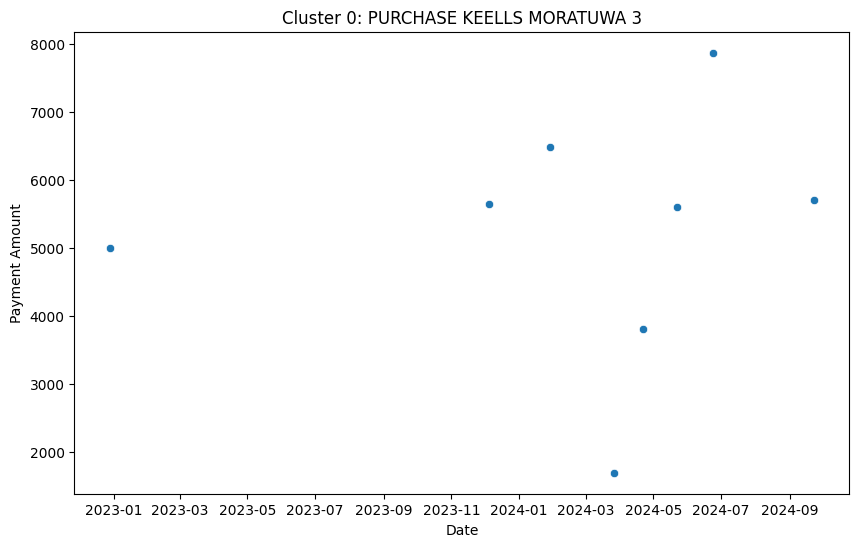

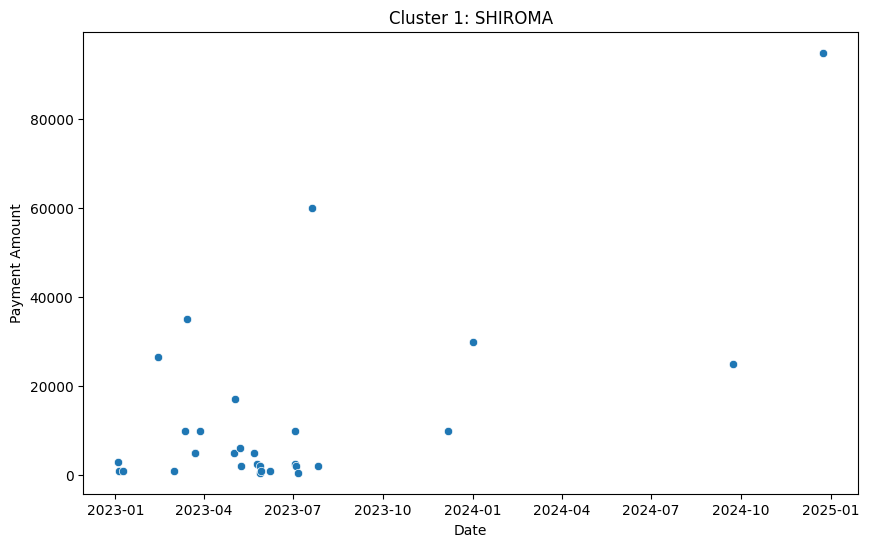

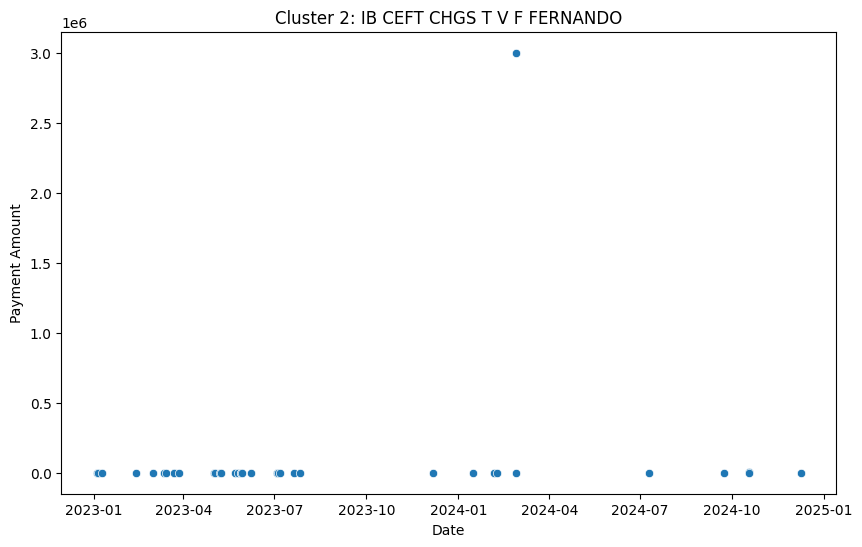

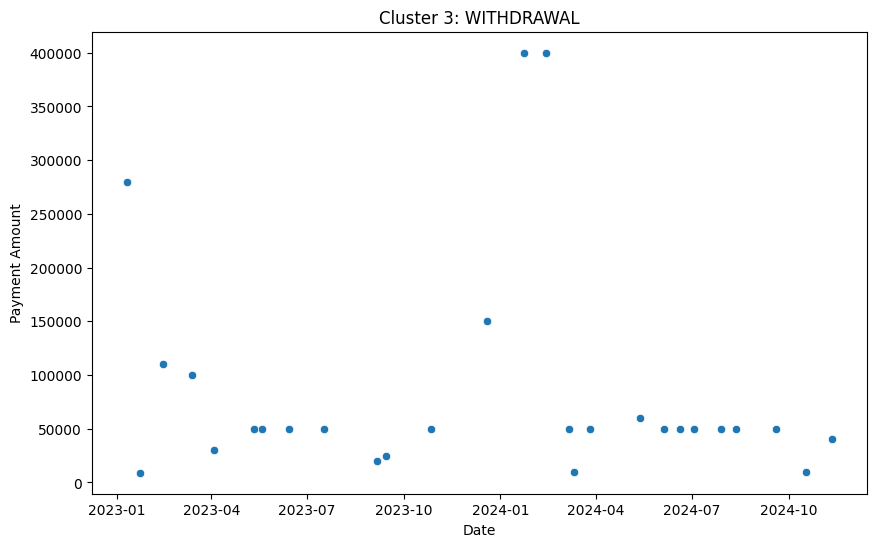

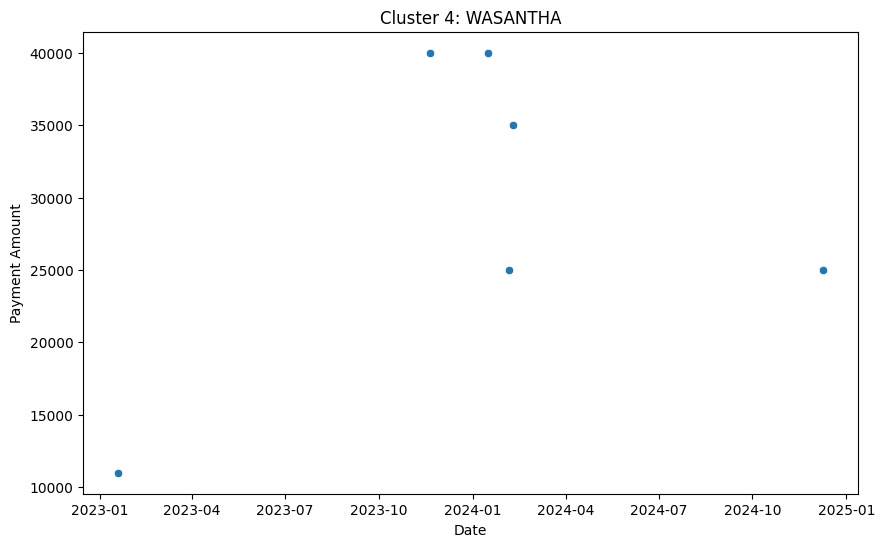

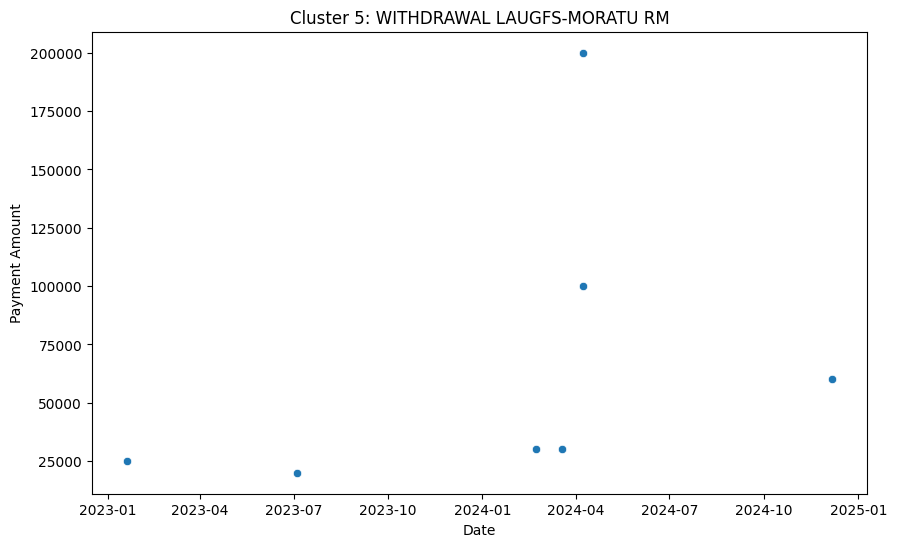

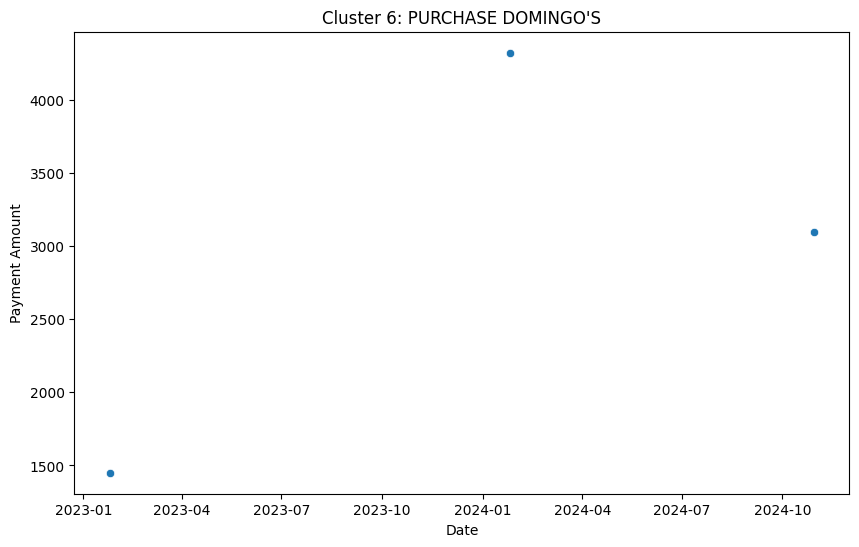

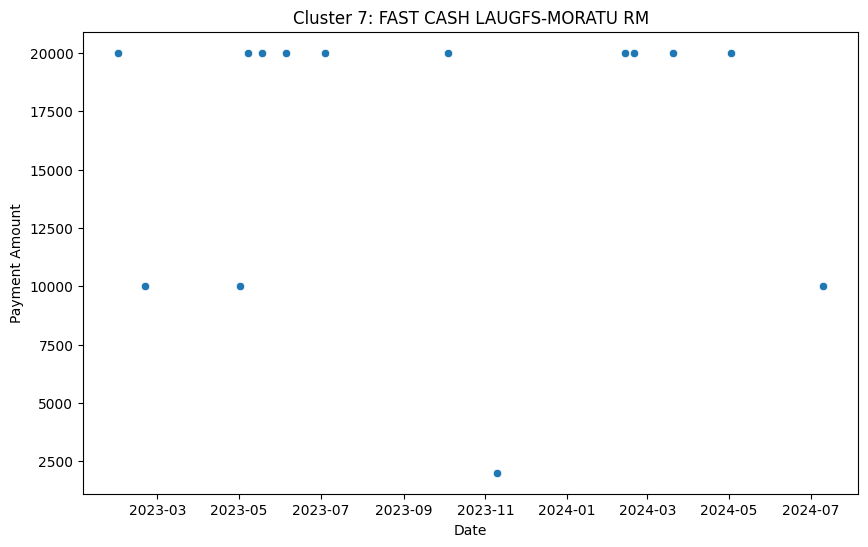

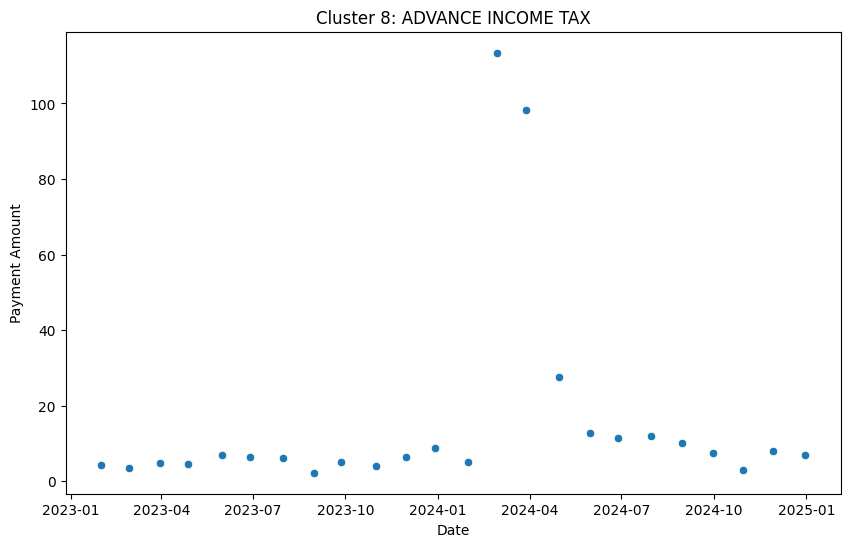

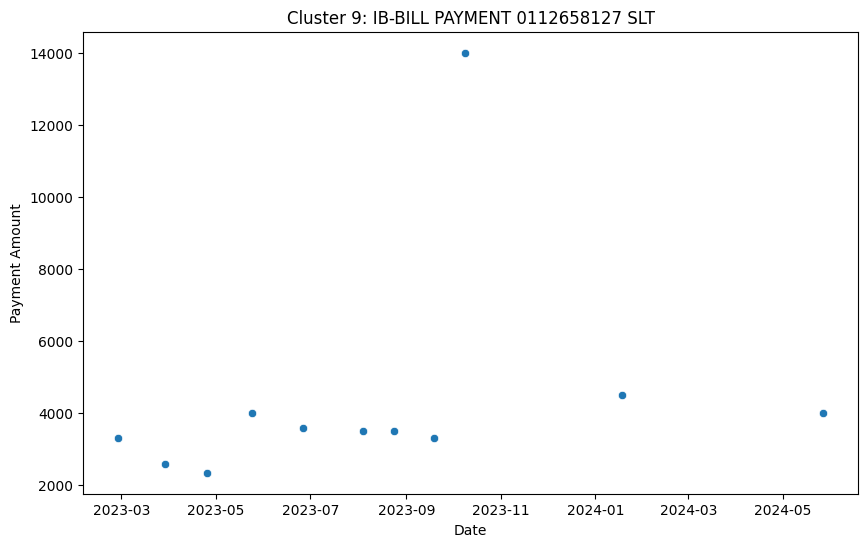

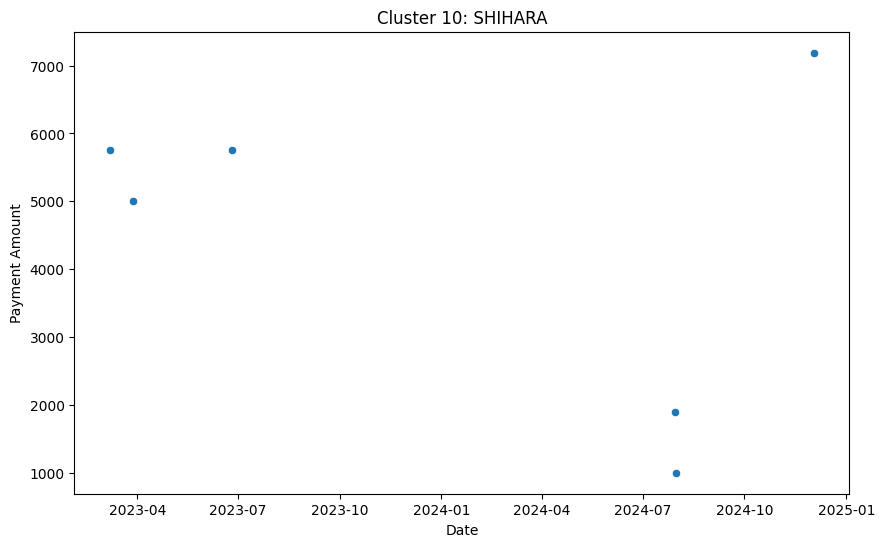

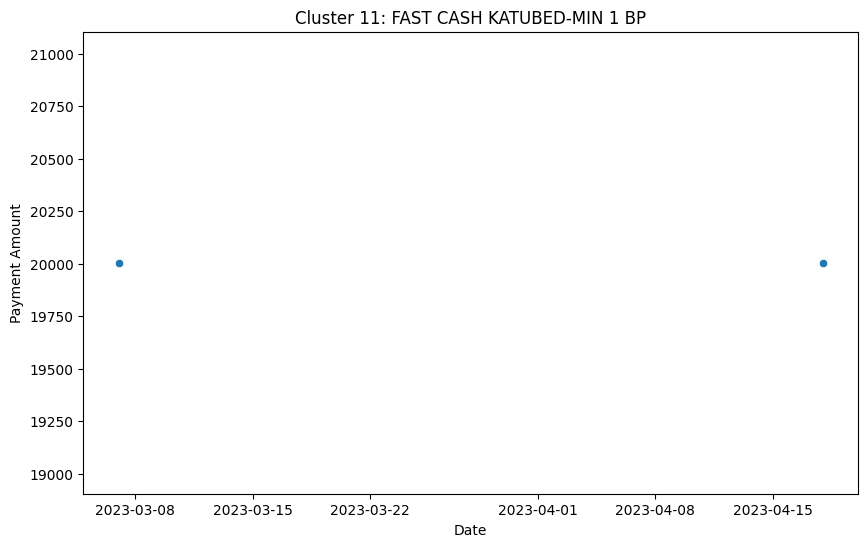

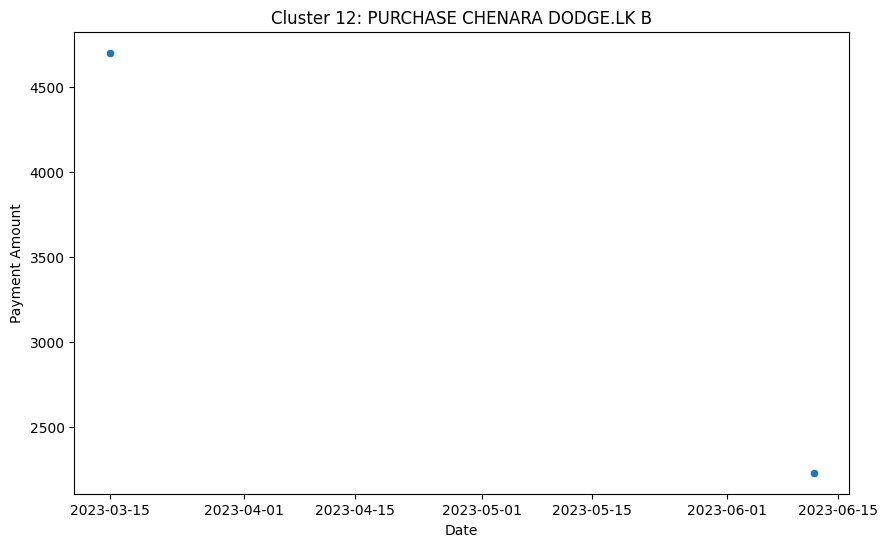

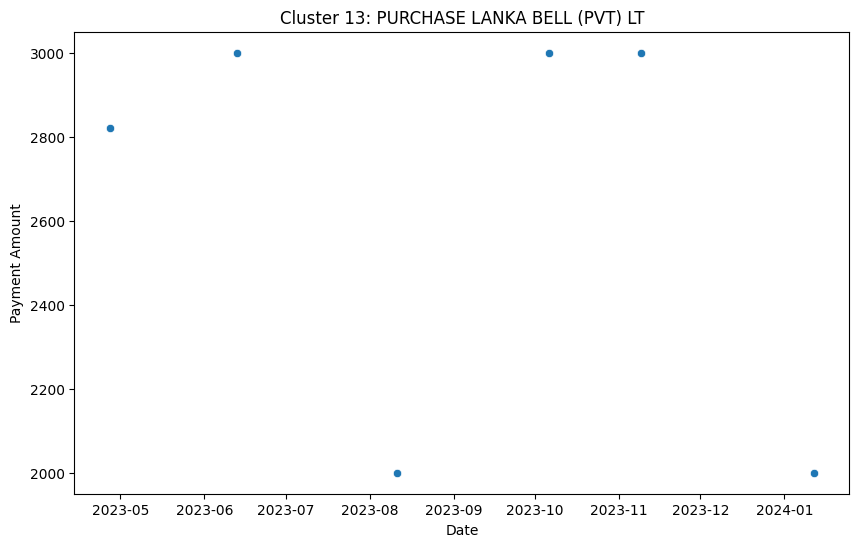

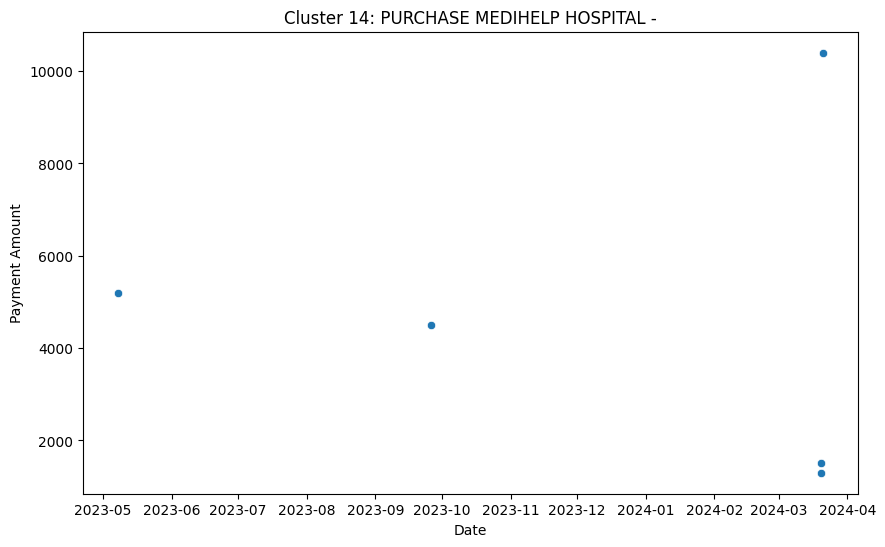

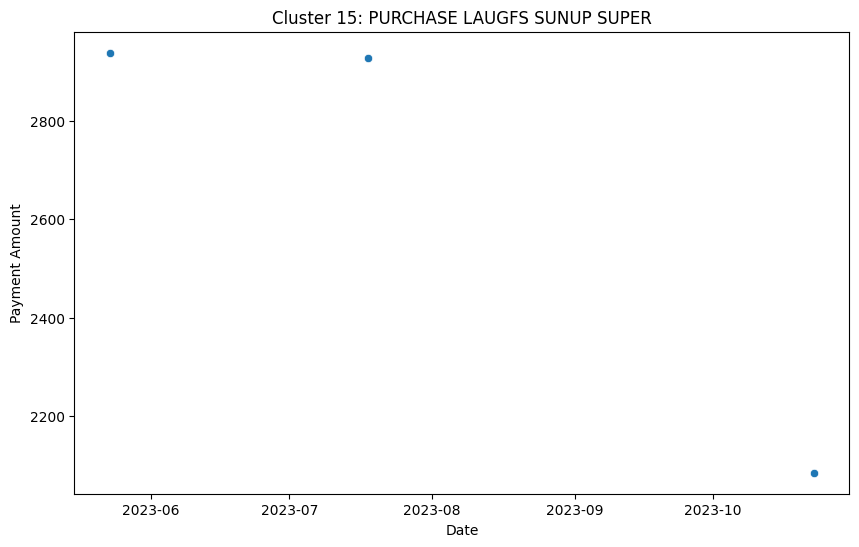

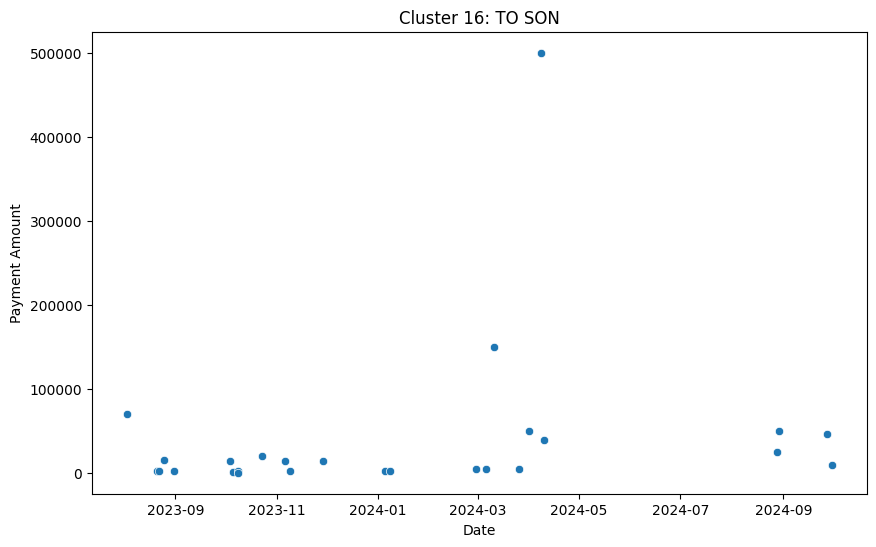

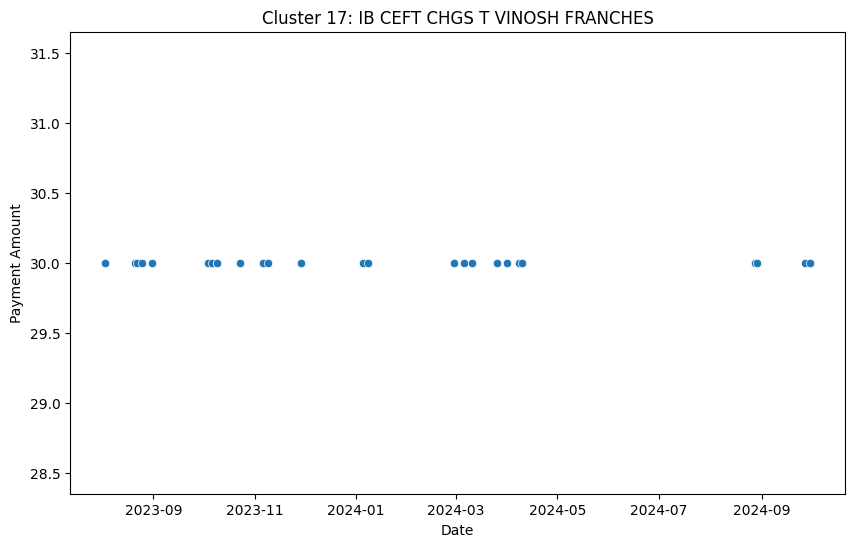

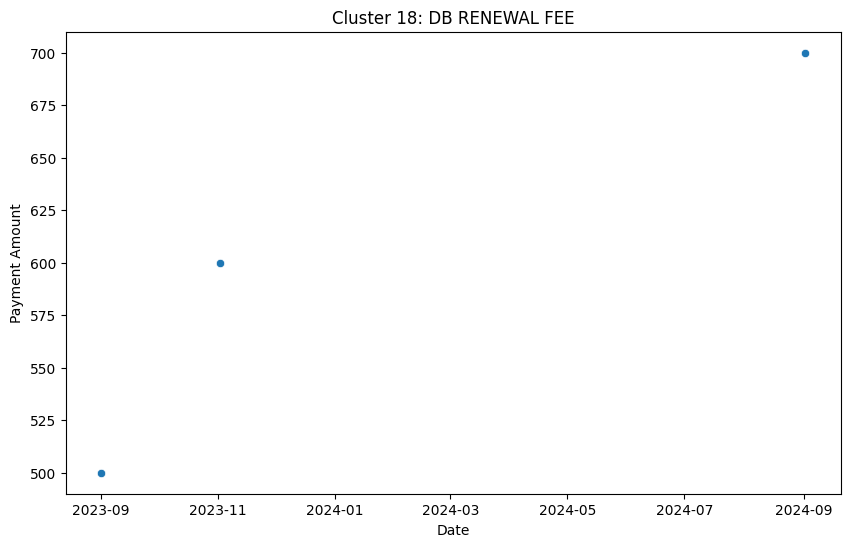

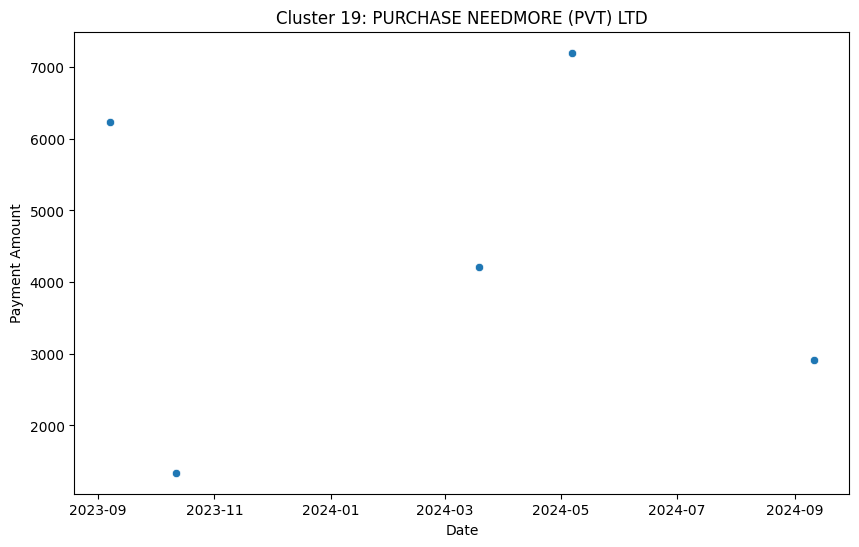

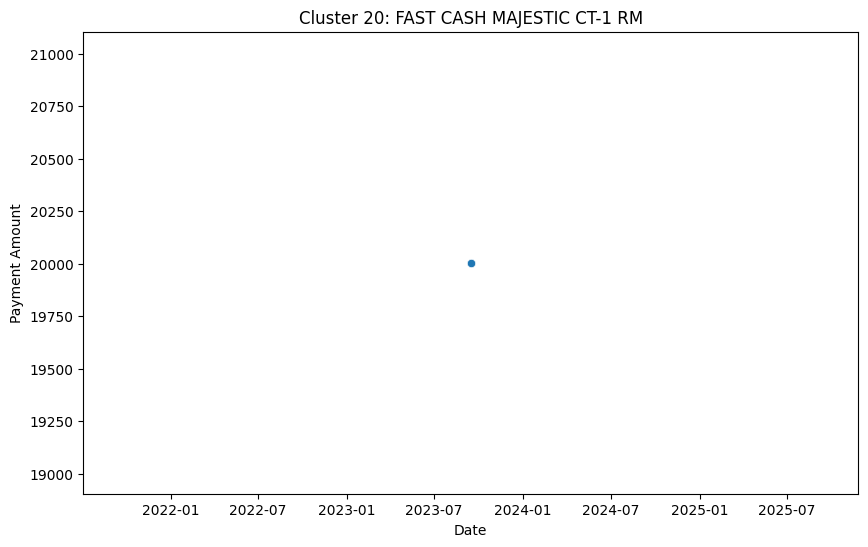

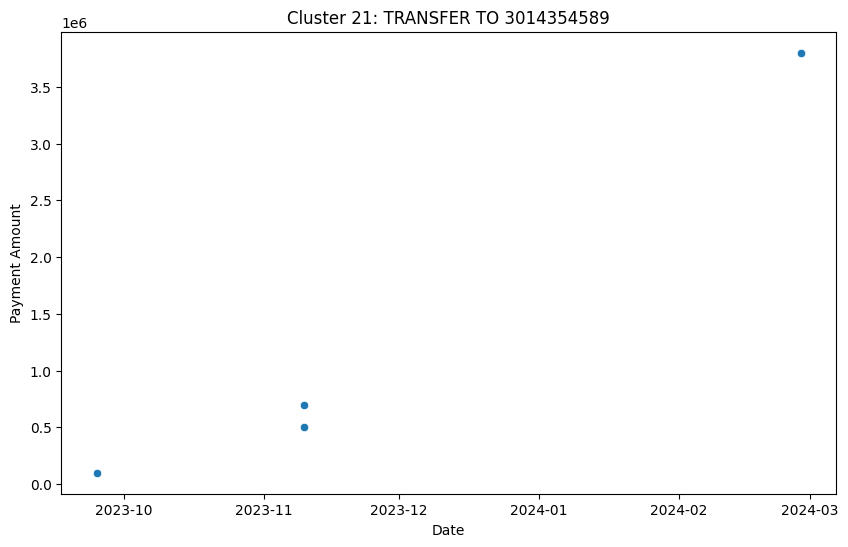

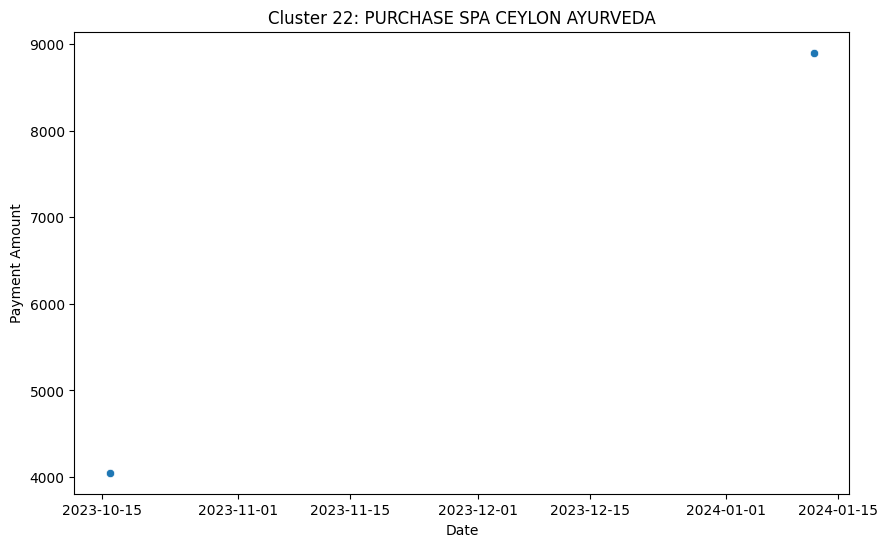

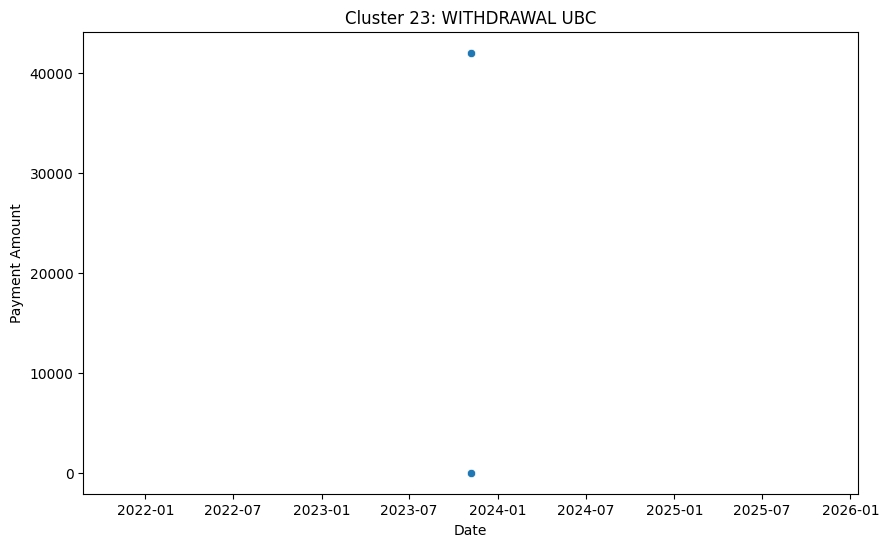

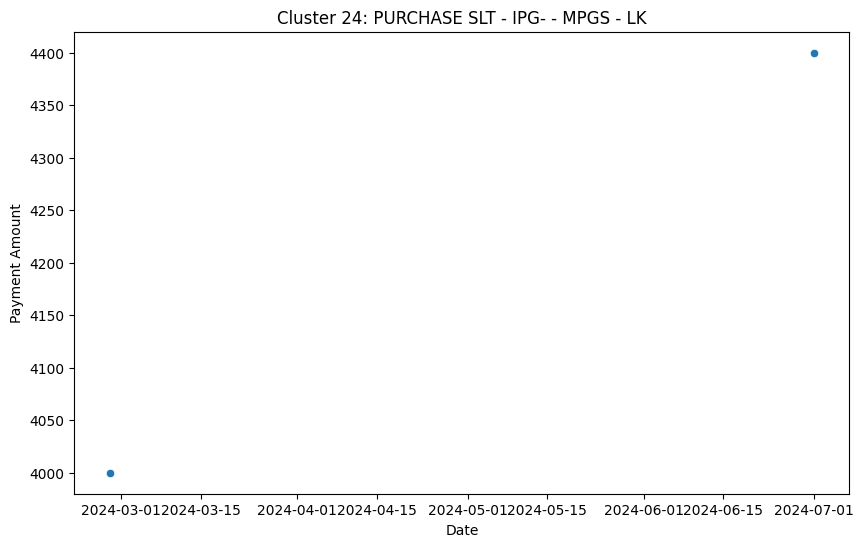

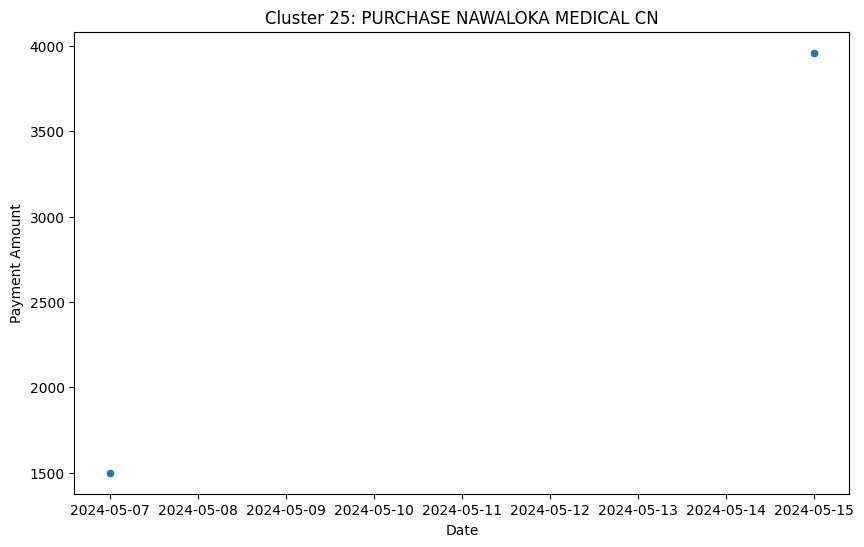

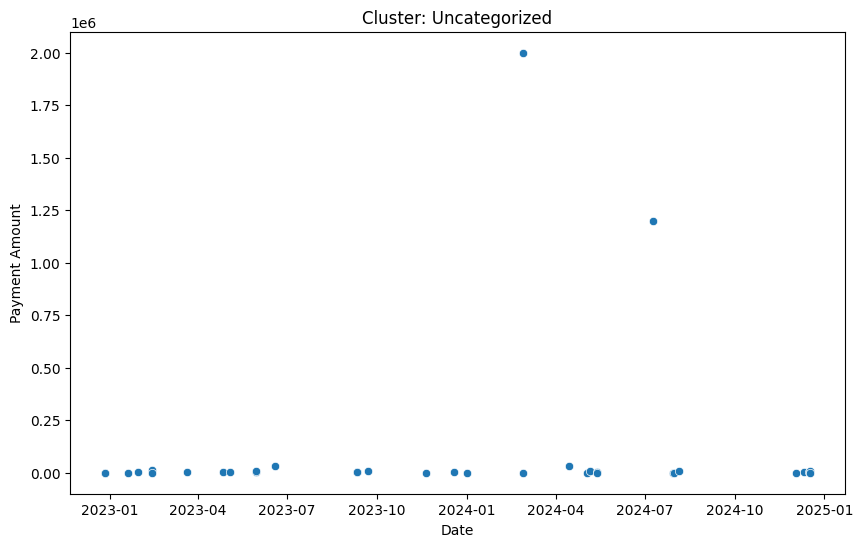

In [ ]:
# prompt: now visualize each dataframe as plots,x azis is data and y axis is payment amount,name each diagram the mane of cluster,category name,i mean Cluster 0: PURCHASE KEELLS MORATUWA 3
# === All Cluster Names ===
# Cluster 0: PURCHASE KEELLS MORATUWA 3
# Cluster 1: SHIROMA
# Cluster 2: IB CEFT CHGS T V F FERNANDO
# Cluster 3: WITHDRAWAL
# Cluster 4: WASANTHA
# Cluster 5: WITHDRAWAL LAUGFS-MORATU RM
# Cluster 6: PURCHASE DOMINGO'S
# Cluster 7: FAST CASH LAUGFS-MORATU RM
# Cluster 8: ADVANCE INCOME TAX
# Cluster 9: IB-BILL PAYMENT 0112658127 SLT
# Cluster 10: SHIHARA
# Cluster 11: FAST CASH KATUBED-MIN 1 BP
# Cluster 12: PURCHASE CHENARA DODGE.LK B
# Cluster 13: PURCHASE LANKA BELL (PVT) LT
# Cluster 14: PURCHASE MEDIHELP HOSPITAL -
# Cluster 15: PURCHASE LAUGFS SUNUP SUPER
# Cluster 16: TO SON
# Cluster 17: IB CEFT CHGS T VINOSH FRANCHES
# Cluster 18: DB RENEWAL FEE
# Cluster 19: PURCHASE NEEDMORE (PVT) LTD
# Cluster 20: FAST CASH MAJESTIC CT-1 RM
# Cluster 21: TRANSFER TO 3014354589
# Cluster 22: PURCHASE SPA CEYLON AYURVEDA
# Cluster 23: WITHDRAWAL UBC
# Cluster 24: PURCHASE SLT - IPG- - MPGS - LK
# Cluster 25: PURCHASE NAWALOKA MEDICAL CN
# Cluster: Uncategorized,first you need generate dictonary to store this names

# Create a dictionary to store cluster names
cluster_names = {}
for cluster in unique_clusters:
    if cluster == -1:
        cluster_names[cluster] = "Uncategorized"
    else:
        # Filter rows for the current cluster
        cluster_data = uncategorized_df[uncategorized_df['Cluster'] == cluster]

        # Automatically assign a name to the cluster based on the most frequent description
        cluster_name = assign_cluster_name(cluster_data)
        cluster_names[cluster] = cluster_name


# Visualize each cluster as a plot
for cluster in unique_clusters:
    if cluster == -1:
        # Handle uncategorized transactions
        cluster_df = uncategorized_df[uncategorized_df['Cluster'] == cluster]
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='Date', y='Payments', data=cluster_df)
        plt.title(f"Cluster: {cluster_names[cluster]}")
        plt.xlabel('Date')
        plt.ylabel('Payment Amount')
        plt.show()

    else:
        # Create a dataframe for each cluster
        cluster_df = uncategorized_df[uncategorized_df['Cluster'] == cluster]
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='Date', y='Payments', data=cluster_df)
        plt.title(f"Cluster {cluster}: {cluster_names[cluster]}")
        plt.xlabel('Date')
        plt.ylabel('Payment Amount')
        plt.show()


<ipython-input-33-6b6f4ae534a8>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_clusters))


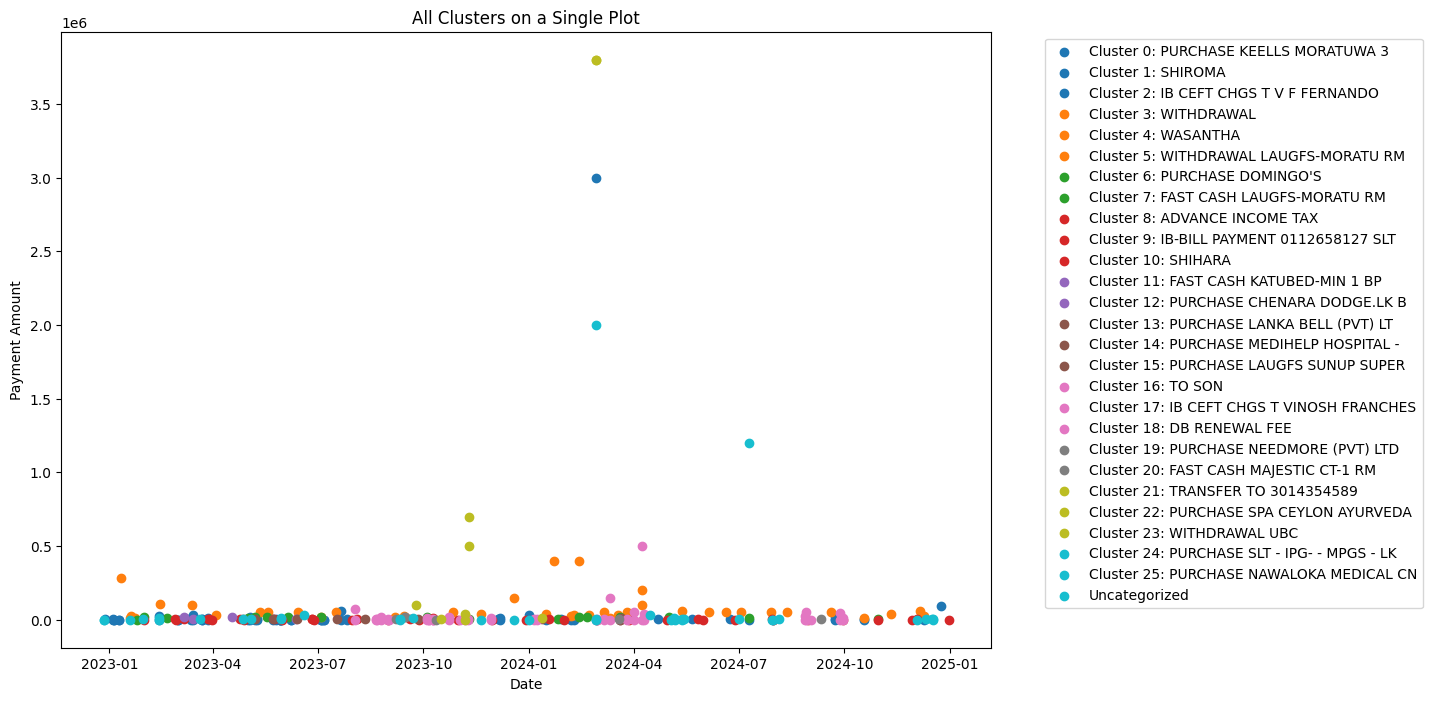

In [ ]:
# prompt: use this all diagrams and plot one diagram,now i need one diagram for plot all this,use defferent color for each one,i mean each category,

plt.figure(figsize=(12, 8))

# Create a color palette with distinct colors for each cluster
colors = plt.cm.get_cmap('tab10', len(unique_clusters))

# Iterate through unique clusters and plot each cluster with a different color
for i, cluster in enumerate(unique_clusters):
    if cluster == -1:
        # Handle uncategorized transactions
        cluster_df = uncategorized_df[uncategorized_df['Cluster'] == cluster]
        plt.scatter(cluster_df['Date'], cluster_df['Payments'], label=cluster_names[cluster], color=colors(i))
    else:
        # Create a dataframe for each cluster
        cluster_df = uncategorized_df[uncategorized_df['Cluster'] == cluster]
        plt.scatter(cluster_df['Date'], cluster_df['Payments'], label=f"Cluster {cluster}: {cluster_names[cluster]}", color=colors(i))

plt.title("All Clusters on a Single Plot")
plt.xlabel('Date')
plt.ylabel('Payment Amount')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
plt.show()



In [ ]:
# prompt: give my all data categories.with all data

print("\n=== Data Categories and Transactions ===")
print(df[['Date', 'Particulars', 'Payments', 'Receipts', 'Balance', 'Category']])

print("\n=== Cluster Labels ===")
print(uncategorized_df[['cleaned_particulars', 'Cluster']])

print("\n=== All Dataframes in cluster_dfs ===")
for df_name, df in cluster_dfs.items():
  print(f"\n=== {df_name} ===")
  print(df)


print("\n=== Cluster Names ===")
cluster_names




=== Data Categories and Transactions ===
          Date                     Particulars    Payments  Receipts  \
0   2022-12-27    IB CEFT CHGS K A Kumaranayek       30.00       NaN   
1   2022-12-27    PURCHASE UNIVERSITY GRANTS C       50.00       NaN   
11  2023-01-19    IB CEFT CHGS W A C D FONSEKA       30.00       NaN   
15  2023-01-30    PURCHASE HOUSE OF FASHIONS-B     2450.00       NaN   
19  2023-02-13                          vinosh    15000.00       NaN   
20  2023-02-13  IB CEFT CHGS Global immigratio       30.00       NaN   
38  2023-03-21               PURCHASE DOUBLE B     2500.00       NaN   
53  2023-04-27      PURCHASE WEBXPAY (PVT) LTD     2440.00       NaN   
61  2023-05-04            PURCHASE SKIN CLINIC     3000.00       NaN   
82  2023-05-30     PURCHASE CARE PLUS PHARMACY     2188.00       NaN   
83  2023-05-30    PURCHASE VISION CARE OPTICAL    10000.00       NaN   
95  2023-06-19     WITHDRAWAL NAWALOKA HOS. RM    30005.00       NaN   
137 2023-09-11    PURC

{np.int64(0): 'PURCHASE KEELLS MORATUWA 3',
 np.int64(1): 'SHIROMA',
 np.int64(2): 'IB CEFT CHGS T V F FERNANDO',
 np.int64(3): 'WITHDRAWAL',
 np.int64(4): 'WASANTHA',
 np.int64(5): 'WITHDRAWAL LAUGFS-MORATU RM',
 np.int64(6): "PURCHASE DOMINGO'S",
 np.int64(7): 'FAST CASH LAUGFS-MORATU RM',
 np.int64(8): 'ADVANCE INCOME TAX',
 np.int64(9): 'IB-BILL PAYMENT 0112658127 SLT',
 np.int64(10): 'SHIHARA',
 np.int64(11): 'FAST CASH KATUBED-MIN 1 BP',
 np.int64(12): 'PURCHASE CHENARA DODGE.LK B',
 np.int64(13): 'PURCHASE LANKA BELL (PVT) LT',
 np.int64(14): 'PURCHASE MEDIHELP HOSPITAL -',
 np.int64(15): 'PURCHASE LAUGFS SUNUP SUPER',
 np.int64(16): 'TO SON',
 np.int64(17): 'IB CEFT CHGS T VINOSH FRANCHES',
 np.int64(18): 'DB RENEWAL FEE',
 np.int64(19): 'PURCHASE NEEDMORE (PVT) LTD',
 np.int64(20): 'FAST CASH MAJESTIC CT-1 RM',
 np.int64(21): 'TRANSFER TO 3014354589',
 np.int64(22): 'PURCHASE SPA CEYLON AYURVEDA',
 np.int64(23): 'WITHDRAWAL UBC',
 np.int64(24): 'PURCHASE SLT - IPG- - MPGS - LK

In [ ]:
# prompt: change of the dataset,i need al dates from start to end in dataset for each category,do this category wise,,if there are no payment or recipts,put it as 0,and then print all categories

from datetime import datetime, timedelta

def category_wise_date_range(df):
  """
  Generates a list of dates from start to end in the dataset for each category.
  If there are no payments or receipts on a date, it is filled with 0.

  Args:
      df: Pandas DataFrame with 'Date', 'Category', 'Payments', and 'Receipts' columns.

  Returns:
      A dictionary with categories as keys and dataframes with dates and corresponding payments/receipts as values.
  """

  category_data = {}
  for category in df['Category'].unique():
    category_df = df[df['Category'] == category].copy()
    if not category_df.empty:
      start_date = category_df['Date'].min()
      end_date = category_df['Date'].max()
      date_range = pd.date_range(start=start_date, end=end_date)
      category_date_df = pd.DataFrame({'Date': date_range})
      category_date_df = pd.merge(category_date_df, category_df[['Date', 'Payments', 'Receipts']], on='Date', how='left')
      category_date_df['Payments'].fillna(0, inplace=True)
      category_date_df['Receipts'].fillna(0, inplace=True)
      category_data[category] = category_date_df

  return category_data

# Assuming your DataFrame is named 'df'
category_date_dict = category_wise_date_range(df)

# Print all categories and their corresponding date-wise payments/receipts
for category, category_df in category_date_dict.items():
  print(f"\nCategory: {category}")
category_df





Category: Uncategorized


<ipython-input-36-ac04551df186>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  category_date_df['Payments'].fillna(0, inplace=True)
<ipython-input-36-ac04551df186>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

,Date,Payments,Receipts
0,2022-12-27,30.00,0.0
1,2022-12-27,50.00,0.0
2,2022-12-28,0.00,0.0
3,2022-12-29,0.00,0.0
4,2022-12-30,0.00,0.0
5,2022-12-31,0.00,0.0
6,2023-01-01,0.00,0.0
7,2023-01-02,0.00,0.0
8,2023-01-03,0.00,0.0
9,2023-01-04,0.00,0.0
